In [1]:
%load_ext autoreload
%autoreload
import os
import numpy as np

import pyrender 
import trimesh
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pyquaternion import Quaternion

import sys
sys.path.append('/Users/yoni/Projects/CommonFate/generator')
import superquadrics

## Superquadrics

A thorough overview of superquadrics: https://cse.buffalo.edu/~jryde/cse673/files/superquadrics.pdf

<!-- ### Implicit Equation
The surface of a basic superquadric is given by: 
$$ \vert x \vert^r + \vert y \vert^s + \vert z \vert^t = 1 ,$$

where $r, s$ and $t$ are positive real numbers that determine the main features of the superquadric:
 - $< 1$ : pointy octahedron
 - $= 1$: regular octahedron
 - $range(1, 2)$: blunt octahedron
 - $=2$ : sphere
 - $>2$ : cube modified to have rounded edges and corners
 
 We can scale these basic shapes as follows: 
 
 $$ \vert \frac{x}{A} \vert^r + \vert \frac{y}{B} \vert^s + \vert \frac{z}{C} \vert^t = 1 $$


### Parametric description

We can describe a superquadric with a parametric equation in terms of surface parameters u (longitude) and v (latitude) by:

\begin{align}
& x(u,v) = Ag\left(v, \frac{2}{r}\right)g\left(u, \frac{2}{r}\right) \\
& y(u,v) = Bg\left(v, \frac{2}{s}\right)f\left(u, \frac{2}{s}\right) \\
& z(u,v) = Cf\left(v, \frac{2}{t}\right) \\
& -\frac{\pi}{2} \leq v \leq \frac{\pi}{2}, \quad -\pi \leq u \leq \pi
\end{align}

The auxilary functions $f$ and $g$ are:

\begin{align}
& f(\omega, m) = sgn(\sin \omega) \vert \sin \omega \vert^m \\
& f(\omega, m) = sgn(\cos \omega) \vert \cos \omega \vert^m \\
\end{align}

where $sgn(x)$ is the sign function (-1 if x < 0, 0 if x == 0, 1 if x > 0)  --> 

In [2]:
def render_one_img(shape, obj_pose=None):
    mesh_node = pyrender.Mesh.from_trimesh(shape)
    scene = pyrender.Scene(bg_color=[300, 300,300])#[500, 500, 500, 1000])
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
    light = pyrender.PointLight(color=[10.0, 100.0, 300.0], intensity=1.5)

    c = 2**-0.5
    pose = [[ 1,  0,  0,  0],
            [ 0,  c, -c, -3],
            [ 0,  c,  c,  3],
            [ 0,  0,  0,  1]]
    
    node = scene.add(mesh_node, pose=np.eye(4))
    scene.add(light, pose=pose)
    scene.add(camera, pose=pose)

    if obj_pose is not None:
        scene.set_pose(node, obj_pose)

    r = pyrender.OffscreenRenderer(640, 480)
    color, depth = r.render(scene)

    fig = plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(color)
    
    return fig, shape

In [10]:
for i in range(150, 154):
    scene = f'scene_{i:03d}'
    print('Scene: ', scene)
    for j in range(1):
        print('Mesh: ', j)
        base_dir = '/Users/yoni/Projects/yifr.github.io/CommonFate/'
        scene_dir = '%s'%scene
        shape = trimesh.load(base_dir + 'scenes/' + scene_dir + '/mesh_%d.obj'%j)
        axis = [-0.5, 1, 1] #np.random.rand(3)
        degrees = 45
        q = Quaternion(axis=axis, degrees=degrees)
        fig, shape = render_one_img(shape, obj_pose=q.transformation_matrix)
        if j == 0:
            title = 'gt_mesh.png'
        else:
            title = f'distractor_{j}.png'
        
        os.makedirs(base_dir + '/images/' + scene_dir, exist_ok=True)
        plt.savefig(base_dir + '/images/' + scene_dir + '/' + title)
        plt.close()
#         plt.title('[{}], axis=[x={}, y={}, z={}], degrees={}'.format(scene, axis[0], axis[1], axis[2], degrees))
#         plt.show()
#scene = pyrender.Scene.from_trimesh_scene(shape)

faces have mixed data, using slow fallback!


Scene:  scene_150
Mesh:  0


faces have mixed data, using slow fallback!


Scene:  scene_151
Mesh:  0


faces have mixed data, using slow fallback!


Scene:  scene_152
Mesh:  0


faces have mixed data, using slow fallback!


Scene:  scene_153
Mesh:  0


In [37]:
def render_img(shape, img_dir, n_frames):
    mesh_node = pyrender.Mesh.from_trimesh(shape)
    scene = pyrender.Scene(ambient_light=[500, 500, 500, 1000])
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
    #light = pyrender.PointLight(color=[100.0, 100.0, 100.0], intensity=10.0)

    c = 2**-0.5
    pose = [[ 1,  0,  0,  0],
         [ 0,  c, -c, -3],
         [ 0,  c,  c,  3],
         [ 0,  0,  0,  1]]

    mesh_node = scene.add(mesh_node, pose=np.eye(4), name='mesh')
    #scene.add(light, pose=np.eye(4))
    camera_node = scene.add(camera, pose=pose)

    r = pyrender.OffscreenRenderer(640, 480)
    rotation_axis = np.random.uniform(-1, 1, size=3)

    fig = plt.figure()
    i = 0
#     q0 = Quaternion(axis=rotation_axis, degrees=0.0) # Rotate 0 about x=y=z
#     q1 = Quaternion(axis=rotation_axis, degrees=180) # Rotate 120 about x=y=z
#     q2 = Quaternion(axis=rotation_axis, degrees=360)
    degrees = np.linspace(0, 360, n_frames)
    for d in tqdm(degrees):
        q = Quaternion(axis=rotation_axis, degrees=d)
        node = list(scene.get_nodes(name='mesh'))[0]
        scene.set_pose(node, q.transformation_matrix)
        print('Rotation matrix: \n{}\nTransformation matrix: \n{}\nElements: {}\nAngle: {}\n\n'.format(
            q.rotation_matrix, q.transformation_matrix,  q.elements, q.angle))
        color, depth = r.render(scene)
        plt.imshow(color)

        plt.axis('off')

#         plt.savefig(img_dir + '/fig_%d.png'%i)
        i += 1
        plt.show()
        plt.clf()
    
    plt.close()
    r.delete()

    return fig, shape

faces have mixed data, using slow fallback!


Rotation matrix: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Transformation matrix: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Elements: [ 1. -0. -0.  0.]
Angle: 0.0




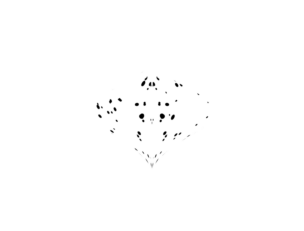

Rotation matrix: 
[[ 9.99501764e-01 -1.92612629e-02 -2.50045635e-02]
 [ 1.92760345e-02  9.99814139e-01  3.49836330e-04]
 [ 2.49931778e-02 -8.31650857e-04  9.99687276e-01]]
Transformation matrix: 
[[ 9.99501764e-01 -1.92612629e-02 -2.50045635e-02  0.00000000e+00]
 [ 1.92760345e-02  9.99814139e-01  3.49836330e-04  0.00000000e+00]
 [ 2.49931778e-02 -8.31650857e-04  9.99687276e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Elements: [ 9.99875390e-01 -2.95408608e-04 -1.25009931e-02  9.63552504e-03]
Angle: 0.031573795513465175




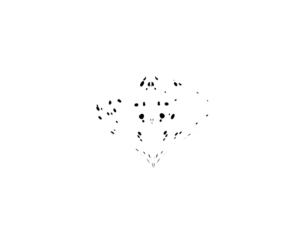

Rotation matrix: 
[[ 9.98007551e-01 -3.84885542e-02 -4.99955875e-02]
 [ 3.85476259e-02  9.99256740e-01  2.17509409e-04]
 [ 4.99500562e-02 -2.14428723e-03  9.98749415e-01]]
Transformation matrix: 
[[ 9.98007551e-01 -3.84885542e-02 -4.99955875e-02  0.00000000e+00]
 [ 3.85476259e-02  9.99256740e-01  2.17509409e-04  0.00000000e+00]
 [ 4.99500562e-02 -2.14428723e-03  9.98749415e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Elements: [ 9.99501589e-01 -5.90743594e-04 -2.49988706e-02  1.92686487e-02]
Angle: 0.06314759102693035




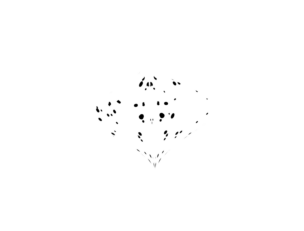

Rotation matrix: 
[[ 9.95518852e-01 -5.76627076e-02 -7.49481605e-02]
 [ 5.77955637e-02  9.98328360e-01 -3.96848858e-04]
 [ 7.48457576e-02 -3.93660067e-03  9.97187352e-01]]
Transformation matrix: 
[[ 9.95518852e-01 -5.76627076e-02 -7.49481605e-02  0.00000000e+00]
 [ 5.77955637e-02  9.98328360e-01 -3.96848858e-04  0.00000000e+00]
 [ 7.48457576e-02 -3.93660067e-03  9.97187352e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Elements: [ 9.98878692e-01 -8.85931354e-04 -3.74905180e-02  2.88969702e-02]
Angle: 0.09472138654039597




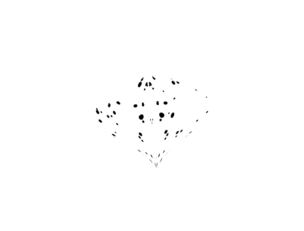

Rotation matrix: 
[[ 0.99203815 -0.07676461 -0.09983741]
 [ 0.07700066  0.99702992 -0.00149263]
 [ 0.09965547 -0.0062068   0.99500265]]
Transformation matrix: 
[[ 0.99203815 -0.07676461 -0.09983741  0.        ]
 [ 0.07700066  0.99702992 -0.00149263  0.        ]
 [ 0.09965547 -0.0062068   0.99500265  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.99800685 -0.0011809  -0.04997282  0.03851809]
Angle: 0.12629518205386114




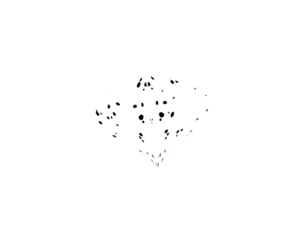

Rotation matrix: 
[[ 0.98756891 -0.09577522 -0.12463852]
 [ 0.09614377  0.99536273 -0.00306873]
 [ 0.12435445 -0.00895264  0.99219747]]
Transformation matrix: 
[[ 0.98756891 -0.09577522 -0.12463852  0.        ]
 [ 0.09614377  0.99536273 -0.00306873  0.        ]
 [ 0.12435445 -0.00895264  0.99219747  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.99688629 -0.00147557 -0.06244267  0.04812961]
Angle: 0.15786897756732632




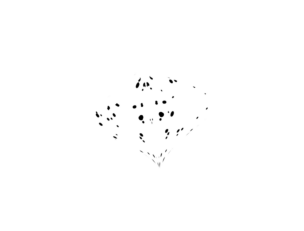

Rotation matrix: 
[[ 0.98211558 -0.11467559 -0.14932678]
 [ 0.11520582  0.99332843 -0.00512359]
 [ 0.14891809 -0.01217136  0.98877463]]
Transformation matrix: 
[[ 0.98211558 -0.11467559 -0.14932678  0.        ]
 [ 0.11520582  0.99332843 -0.00512359  0.        ]
 [ 0.14891809 -0.01217136  0.98877463  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.99551728 -0.00176988 -0.07489696  0.05772914]
Angle: 0.1894427730807915




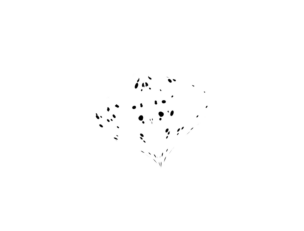

Rotation matrix: 
[[ 0.97568362 -0.13344687 -0.17387757]
 [ 0.1341678   0.99092906 -0.00765516]
 [ 0.1733219  -0.01585976  0.98473752]]
Transformation matrix: 
[[ 0.97568362 -0.13344687 -0.17387757  0.        ]
 [ 0.1341678   0.99092906 -0.00765516  0.        ]
 [ 0.1733219  -0.01585976  0.98473752  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.99390017 -0.00206374 -0.08733258  0.06731427]
Angle: 0.22101656859425667




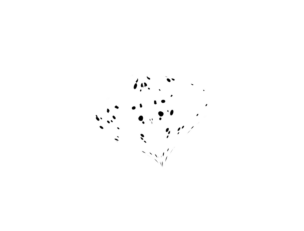

Rotation matrix: 
[[ 0.96827942 -0.15207036 -0.19826642]
 [ 0.15301081  0.98816701 -0.01066091]
 [ 0.19754155 -0.02001417  0.98009018]]
Transformation matrix: 
[[ 0.96827942 -0.15207036 -0.19826642  0.        ]
 [ 0.15301081  0.98816701 -0.01066091  0.        ]
 [ 0.19754155 -0.02001417  0.98009018  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.99203536 -0.00235709 -0.09974644  0.07688264]
Angle: 0.2525903641077223




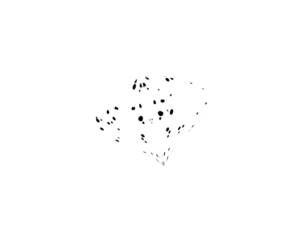

Rotation matrix: 
[[ 0.95991036 -0.1705275  -0.22246903]
 [ 0.17171606  0.98504503 -0.01413784]
 [ 0.2215529  -0.02463044  0.97483724]]
Transformation matrix: 
[[ 0.95991036 -0.1705275  -0.22246903  0.        ]
 [ 0.17171606  0.98504503 -0.01413784  0.        ]
 [ 0.2215529  -0.02463044  0.97483724  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.98992331 -0.00264985 -0.11213544  0.08643184]
Angle: 0.28416415962118746




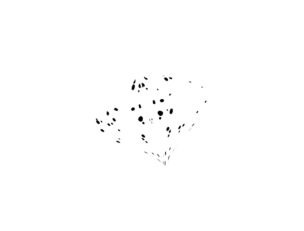

Rotation matrix: 
[[ 0.9505848  -0.18879987 -0.24646125]
 [ 0.19026492  0.98156624 -0.0180825 ]
 [ 0.24533202 -0.02970398  0.96898394]]
Transformation matrix: 
[[ 0.9505848  -0.18879987 -0.24646125  0.        ]
 [ 0.19026492  0.98156624 -0.0180825   0.        ]
 [ 0.24533202 -0.02970398  0.96898394  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.98756455 -0.00294195 -0.12449649  0.0959595 ]
Angle: 0.31573795513465264




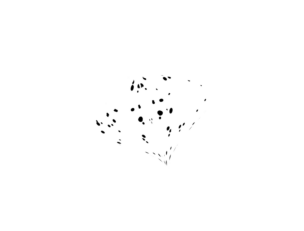

Rotation matrix: 
[[ 0.94031202 -0.20686927 -0.27021918]
 [ 0.20863889  0.9777341  -0.02249095]
 [ 0.2688552  -0.03522972  0.9625361 ]]
Transformation matrix: 
[[ 0.94031202 -0.20686927 -0.27021918  0.        ]
 [ 0.20863889  0.9777341  -0.02249095  0.        ]
 [ 0.2688552  -0.03522972  0.9625361   0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.98495967 -0.00323332 -0.13682651  0.10546324]
Angle: 0.3473117506481178




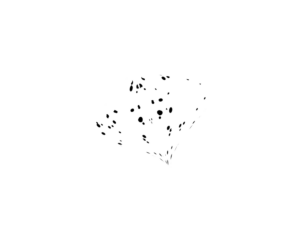

Rotation matrix: 
[[ 0.92910227 -0.22471769 -0.29371914]
 [ 0.22681965  0.97355243 -0.0273588 ]
 [ 0.29209899 -0.04120215  0.95550016]]
Transformation matrix: 
[[ 0.92910227 -0.22471769 -0.29371914  0.        ]
 [ 0.22681965  0.97355243 -0.0273588   0.        ]
 [ 0.29209899 -0.04120215  0.95550016  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.98210932 -0.00352388 -0.14912243  0.1149407 ]
Angle: 0.378885546161583




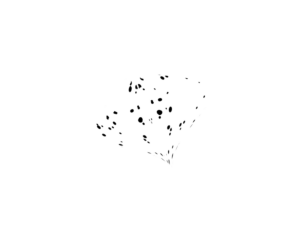

Rotation matrix: 
[[ 0.91696671 -0.24232734 -0.3169377 ]
 [ 0.24478909  0.96902541 -0.03268118]
 [ 0.31504023 -0.04761533  0.94788313]]
Transformation matrix: 
[[ 0.91696671 -0.24232734 -0.3169377   0.        ]
 [ 0.24478909  0.96902541 -0.03268118  0.        ]
 [ 0.31504023 -0.04761533  0.94788313  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.97901421 -0.00381357 -0.16138119  0.12438952]
Angle: 0.4104593416750486




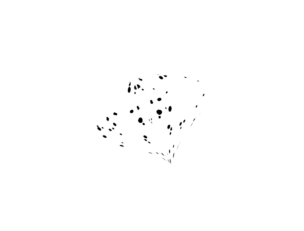

Rotation matrix: 
[[ 0.90391746 -0.25968066 -0.33985171]
 [ 0.26252929  0.96415754 -0.03845281]
 [ 0.33765604 -0.05446286  0.93969261]]
Transformation matrix: 
[[ 0.90391746 -0.25968066 -0.33985171  0.        ]
 [ 0.26252929  0.96415754 -0.03845281  0.        ]
 [ 0.33765604 -0.05446286  0.93969261  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.9756751  -0.0041023  -0.17359973  0.13380734]
Angle: 0.4420331371885138




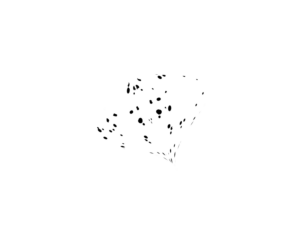

Rotation matrix: 
[[ 0.88996751 -0.27676034 -0.36243834]
 [ 0.28002256  0.95895367 -0.04466791]
 [ 0.35992388 -0.06173792  0.93093675]]
Transformation matrix: 
[[ 0.88996751 -0.27676034 -0.36243834  0.        ]
 [ 0.28002256  0.95895367 -0.04466791  0.        ]
 [ 0.35992388 -0.06173792  0.93093675  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.97209284 -0.00439001 -0.18577501  0.1431918 ]
Angle: 0.47360693270197896




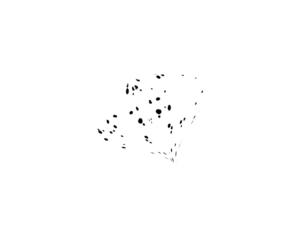

Rotation matrix: 
[[ 0.87513076 -0.29354938 -0.38467507]
 [ 0.29725148  0.953419   -0.05132031]
 [ 0.38182156 -0.06943325  0.92162428]]
Transformation matrix: 
[[ 0.87513076 -0.29354938 -0.38467507  0.        ]
 [ 0.29725148  0.953419   -0.05132031  0.        ]
 [ 0.38182156 -0.06943325  0.92162428  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.96826831 -0.00467663 -0.19790399  0.15254059]
Angle: 0.5051807282154441




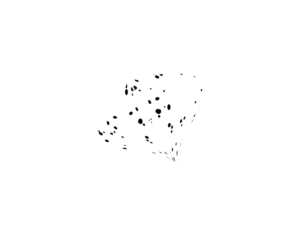

Rotation matrix: 
[[ 0.85942202 -0.31003103 -0.40653973]
 [ 0.31419886  0.94755904 -0.05840337]
 [ 0.40332725 -0.07754118  0.9117645 ]]
Transformation matrix: 
[[ 0.85942202 -0.31003103 -0.40653973  0.        ]
 [ 0.31419886  0.94755904 -0.05840337  0.        ]
 [ 0.40332725 -0.07754118  0.9117645   0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.96420246 -0.00496208 -0.20998364  0.16185135]
Angle: 0.5367545237289093




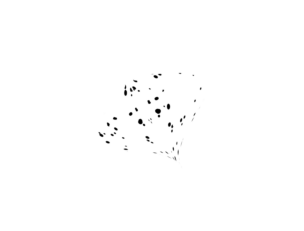

Rotation matrix: 
[[ 0.84285694 -0.32618886 -0.42801052]
 [ 0.33084781  0.94137963 -0.06591002]
 [ 0.4244195  -0.08605363  0.90136722]]
Transformation matrix: 
[[ 0.84285694 -0.32618886 -0.42801052  0.        ]
 [ 0.33084781  0.94137963 -0.06591002  0.        ]
 [ 0.4244195  -0.08605363  0.90136722  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.95989632 -0.0052463  -0.22201096  0.17112178]
Angle: 0.5683283192423749




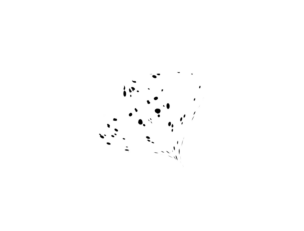

Rotation matrix: 
[[ 0.82545203 -0.34200677 -0.44906606]
 [ 0.34718173  0.93488693 -0.07383278]
 [ 0.4450773  -0.09496211  0.89044281]]
Transformation matrix: 
[[ 0.82545203 -0.34200677 -0.44906606  0.        ]
 [ 0.34718173  0.93488693 -0.07383278  0.        ]
 [ 0.4450773  -0.09496211  0.89044281  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.95535095 -0.00552921 -0.23398295  0.18034956]
Angle: 0.5999021147558401




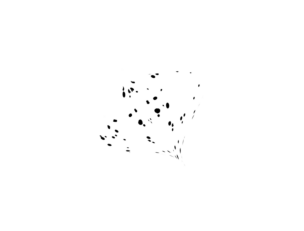

Rotation matrix: 
[[ 0.80722463 -0.35746899 -0.46968534]
 [ 0.36318435  0.92808741 -0.08216376]
 [ 0.46528005 -0.10425775  0.87900216]]
Transformation matrix: 
[[ 0.80722463 -0.35746899 -0.46968534  0.        ]
 [ 0.36318435  0.92808741 -0.08216376  0.        ]
 [ 0.46528005 -0.10425775  0.87900216  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.95056749 -0.00581074 -0.24589663  0.1895324 ]
Angle: 0.6314759102693053




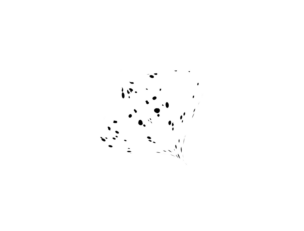

Rotation matrix: 
[[ 0.78819293 -0.3725601  -0.48984781]
 [ 0.37883971  0.92098786 -0.09089465]
 [ 0.48500761 -0.11393128  0.86705668]]
Transformation matrix: 
[[ 0.78819293 -0.3725601  -0.48984781  0.        ]
 [ 0.37883971  0.92098786 -0.09089465  0.        ]
 [ 0.48500761 -0.11393128  0.86705668  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.94554713 -0.00609082 -0.25774903  0.198668  ]
Angle: 0.6630497057827704




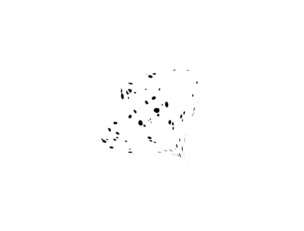

Rotation matrix: 
[[ 0.76837589 -0.38726506 -0.50953338]
 [ 0.3941322   0.91359534 -0.10001676]
 [ 0.50424032 -0.12397305  0.85461827]]
Transformation matrix: 
[[ 0.76837589 -0.38726506 -0.50953338  0.        ]
 [ 0.3941322   0.91359534 -0.10001676  0.        ]
 [ 0.50424032 -0.12397305  0.85461827  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.94029111 -0.00636938 -0.26953719  0.20775408]
Angle: 0.6946235012962356




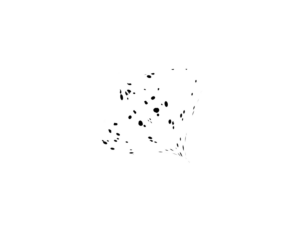

Rotation matrix: 
[[ 0.74779326 -0.40156922 -0.52872242]
 [ 0.40904659  0.90591724 -0.10952097]
 [ 0.522959   -0.13437306  0.84169933]]
Transformation matrix: 
[[ 0.74779326 -0.40156922 -0.52872242  0.        ]
 [ 0.40904659  0.90591724 -0.10952097  0.        ]
 [ 0.522959   -0.13437306  0.84169933  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.93480076 -0.00664636 -0.28125818  0.21678839]
Angle: 0.7261972968097008




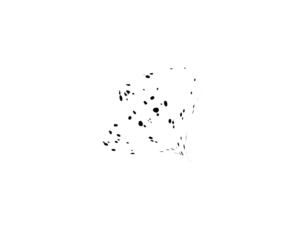

Rotation matrix: 
[[ 0.72646557 -0.41545832 -0.5473958 ]
 [ 0.42356801  0.89796119 -0.11939783]
 [ 0.54114501 -0.14512093  0.82831274]]
Transformation matrix: 
[[ 0.72646557 -0.41545832 -0.5473958   0.        ]
 [ 0.42356801  0.89796119 -0.11939783  0.        ]
 [ 0.54114501 -0.14512093  0.82831274  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.92907743 -0.00692168 -0.29290907  0.22576867]
Angle: 0.757771092323166




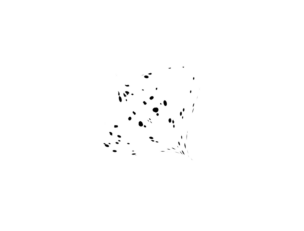

Rotation matrix: 
[[ 0.70441407 -0.4289185  -0.56553491]
 [ 0.43768197  0.88973514 -0.12963749]
 [ 0.5587802  -0.15620596  0.81447184]]
Transformation matrix: 
[[ 0.70441407 -0.4289185  -0.56553491  0.        ]
 [ 0.43768197  0.88973514 -0.12963749  0.        ]
 [ 0.5587802  -0.15620596  0.81447184  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.92312256 -0.00719527 -0.30448696  0.23469269]
Angle: 0.7893448878366316




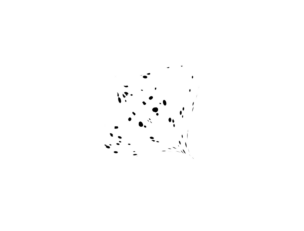

Rotation matrix: 
[[ 0.68166074 -0.44193636 -0.58312168]
 [ 0.45137441  0.88124728 -0.14022973]
 [ 0.575847   -0.1676171   0.80019044]]
Transformation matrix: 
[[ 0.68166074 -0.44193636 -0.58312168  0.        ]
 [ 0.45137441  0.88124728 -0.14022973  0.        ]
 [ 0.575847   -0.1676171   0.80019044  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.91693763 -0.00746708 -0.31598896  0.24355822]
Angle: 0.8209186833500968




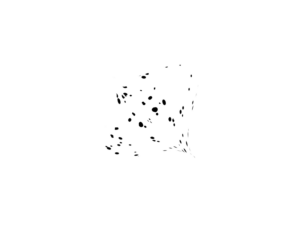

Rotation matrix: 
[[ 0.65822827 -0.45449891 -0.60013855]
 [ 0.46463169  0.87250607 -0.15116401]
 [ 0.59232841 -0.17934297  0.78548276]]
Transformation matrix: 
[[ 0.65822827 -0.45449891 -0.60013855  0.        ]
 [ 0.46463169  0.87250607 -0.15116401  0.        ]
 [ 0.59232841 -0.17934297  0.78548276  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.91052418 -0.00773702 -0.32741222  0.25236304]
Angle: 0.8524924788635619




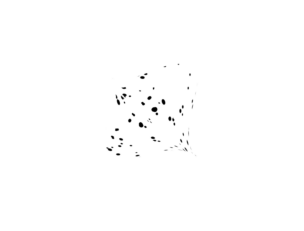

Rotation matrix: 
[[ 0.63414001 -0.46659364 -0.61656859]
 [ 0.47744058  0.86352023 -0.16242941]
 [ 0.60820798 -0.19137187  0.77036346]]
Transformation matrix: 
[[ 0.63414001 -0.46659364 -0.61656859  0.        ]
 [ 0.47744058  0.86352023 -0.16242941  0.        ]
 [ 0.60820798 -0.19137187  0.77036346  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.9038838  -0.00800503 -0.33875388  0.26110497]
Angle: 0.8840662743770276




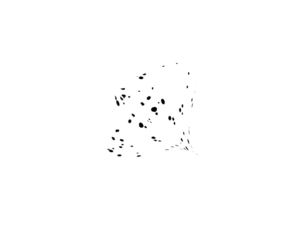

Rotation matrix: 
[[ 0.60941998 -0.47820849 -0.6323954 ]
 [ 0.48978832  0.85429871 -0.17401472]
 [ 0.62346988 -0.20369183  0.75484763]]
Transformation matrix: 
[[ 0.60941998 -0.47820849 -0.6323954   0.        ]
 [ 0.48978832  0.85429871 -0.17401472  0.        ]
 [ 0.62346988 -0.20369183  0.75484763  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.89701816 -0.00827105 -0.35001111  0.26978183]
Angle: 0.9156400698904923




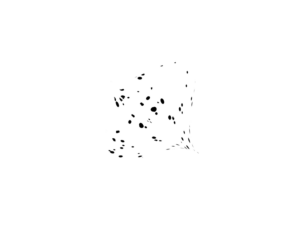

Rotation matrix: 
[[ 0.58409281 -0.48933187 -0.64760321]
 [ 0.5016626   0.8448507  -0.18590838]
 [ 0.63809892 -0.21629056  0.73895072]]
Transformation matrix: 
[[ 0.58409281 -0.48933187 -0.64760321  0.        ]
 [ 0.5016626   0.8448507  -0.18590838  0.        ]
 [ 0.63809892 -0.21629056  0.73895072  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.88992896 -0.008535   -0.36118111  0.27839145]
Angle: 0.9472138654039579




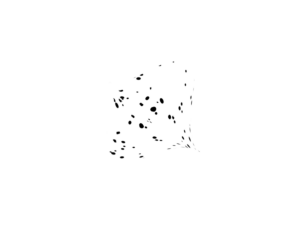

Rotation matrix: 
[[ 0.55818375 -0.49995271 -0.66217686]
 [ 0.51305158  0.83518563 -0.19809853]
 [ 0.6520805  -0.2291555   0.72268858]]
Transformation matrix: 
[[ 0.55818375 -0.49995271 -0.66217686  0.        ]
 [ 0.51305158  0.83518563 -0.19809853  0.        ]
 [ 0.6520805  -0.2291555   0.72268858  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.88261798 -0.00879683 -0.3722611   0.2869317 ]
Angle: 0.9787876609174226




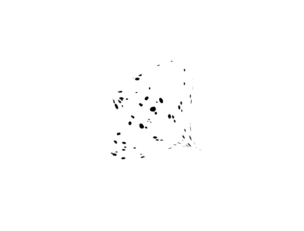

Rotation matrix: 
[[ 0.53171863 -0.51006041 -0.67610182]
 [ 0.52394392  0.82531313 -0.21057304]
 [ 0.66540068 -0.24227383  0.70607742]]
Transformation matrix: 
[[ 0.53171863 -0.51006041 -0.67610182  0.        ]
 [ 0.52394392  0.82531313 -0.21057304  0.        ]
 [ 0.66540068 -0.24227383  0.70607742  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.87508702 -0.00905647 -0.38324831  0.29540043]
Angle: 1.0103614564308883




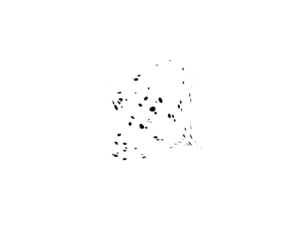

Rotation matrix: 
[[ 0.50472384 -0.5196449  -0.68936422]
 [ 0.53432874  0.81524304 -0.22331945]
 [ 0.67804619 -0.25563247  0.6891338 ]]
Transformation matrix: 
[[ 0.50472384 -0.5196449  -0.68936422  0.        ]
 [ 0.53432874  0.81524304 -0.22331945  0.        ]
 [ 0.67804619 -0.25563247  0.6891338   0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.86733798 -0.00931385 -0.39414001  0.30379554]
Angle: 1.0419352519443539




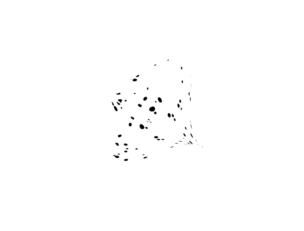

Rotation matrix: 
[[ 0.47722627 -0.52869663 -0.70195083]
 [ 0.54419571  0.8049854  -0.23632507]
 [ 0.69000443 -0.2692181   0.67187462]]
Transformation matrix: 
[[ 0.47722627 -0.52869663 -0.70195083  0.        ]
 [ 0.54419571  0.8049854  -0.23632507  0.        ]
 [ 0.69000443 -0.2692181   0.67187462  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.85937278 -0.00956891 -0.40493349  0.31211494]
Angle: 1.0735090474578186




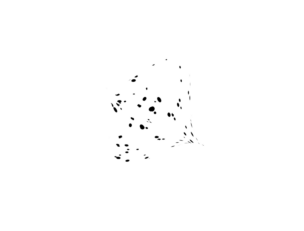

Rotation matrix: 
[[ 0.44925334 -0.53720657 -0.7138491 ]
 [ 0.55353499  0.79455042 -0.24957693]
 [ 0.70126347 -0.28301718  0.65431706]]
Transformation matrix: 
[[ 0.44925334 -0.53720657 -0.7138491   0.        ]
 [ 0.55353499  0.79455042 -0.24957693  0.        ]
 [ 0.70126347 -0.28301718  0.65431706  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.8511934  -0.00982158 -0.41562604  0.32035656]
Angle: 1.1050828429712842




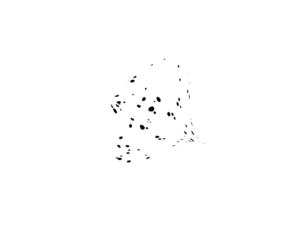

Rotation matrix: 
[[ 0.42083294 -0.54516624 -0.72504718]
 [ 0.56233726  0.78394853 -0.26306182]
 [ 0.71181209 -0.29701597  0.63647865]]
Transformation matrix: 
[[ 0.42083294 -0.54516624 -0.72504718  0.        ]
 [ 0.56233726  0.78394853 -0.26306182  0.        ]
 [ 0.71181209 -0.29701597  0.63647865  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.84280189 -0.01007181 -0.42621501  0.32851833]
Angle: 1.1366566384847498




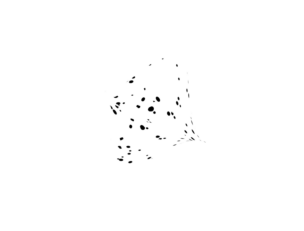

Rotation matrix: 
[[ 0.39199339 -0.5525677  -0.7355339 ]
 [ 0.57059375  0.77319027 -0.27676629]
 [ 0.72163977 -0.31120049  0.61837715]]
Transformation matrix: 
[[ 0.39199339 -0.5525677  -0.7355339   0.        ]
 [ 0.57059375  0.77319027 -0.27676629  0.        ]
 [ 0.72163977 -0.31120049  0.61837715  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.83420034 -0.01031952 -0.43669776  0.33659824]
Angle: 1.1682304339982146




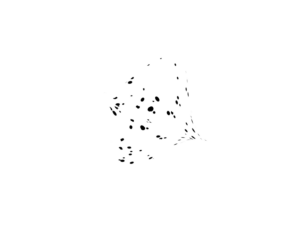

Rotation matrix: 
[[ 0.36276344 -0.55940358 -0.74529882]
 [ 0.57829623  0.76228638 -0.2906767 ]
 [ 0.73073672 -0.32555662  0.60003061]]
Transformation matrix: 
[[ 0.36276344 -0.55940358 -0.74529882  0.        ]
 [ 0.57829623  0.76228638 -0.2906767   0.        ]
 [ 0.73073672 -0.32555662  0.60003061  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.82539088 -0.01056467 -0.44707168  0.34459425]
Angle: 1.1998042295116802




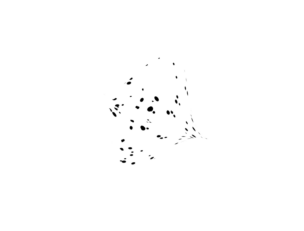

Rotation matrix: 
[[ 0.33317223 -0.56566706 -0.75433218]
 [ 0.58543703  0.75124773 -0.30477917]
 [ 0.73909387 -0.34007004  0.58145732]]
Transformation matrix: 
[[ 0.33317223 -0.56566706 -0.75433218  0.        ]
 [ 0.58543703  0.75124773 -0.30477917  0.        ]
 [ 0.73909387 -0.34007004  0.58145732  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.81637572 -0.01080718 -0.45733417  0.35250438]
Angle: 1.231378025025145




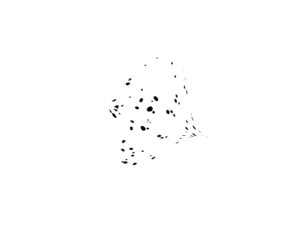

Rotation matrix: 
[[ 0.30324925 -0.5713519  -0.762625  ]
 [ 0.59200902  0.74008531 -0.31905964]
 [ 0.7467029  -0.35472628  0.5626758 ]]
Transformation matrix: 
[[ 0.30324925 -0.5713519  -0.762625    0.        ]
 [ 0.59200902  0.74008531 -0.31905964  0.        ]
 [ 0.7467029  -0.35472628  0.5626758   0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.8071571  -0.011047   -0.46748269  0.36032667]
Angle: 1.2629518205386105




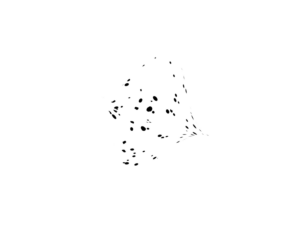

Rotation matrix: 
[[ 0.27302434 -0.57645243 -0.77016901]
 [ 0.59800565  0.72881026 -0.33350388]
 [ 0.7535562  -0.36951074  0.54370476]]
Transformation matrix: 
[[ 0.27302434 -0.57645243 -0.77016901  0.        ]
 [ 0.59800565  0.72881026 -0.33350388  0.        ]
 [ 0.7535562  -0.36951074  0.54370476  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.79773733 -0.01128406 -0.4775147   0.36805915]
Angle: 1.2945256160520753




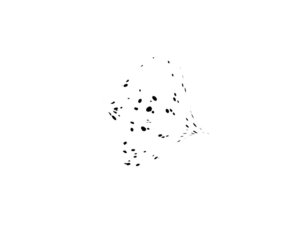

Rotation matrix: 
[[ 0.24252762 -0.58096358 -0.77695668]
 [ 0.60342095  0.71743382 -0.34809749]
 [ 0.75964696 -0.38440868  0.52456311]]
Transformation matrix: 
[[ 0.24252762 -0.58096358 -0.77695668  0.        ]
 [ 0.60342095  0.71743382 -0.34809749  0.        ]
 [ 0.75964696 -0.38440868  0.52456311  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.78811873 -0.01151831 -0.48742771  0.3756999 ]
Angle: 1.326099411565541




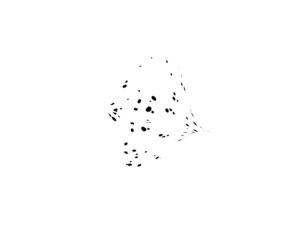

Rotation matrix: 
[[ 0.2117895  -0.58488083 -0.78298124]
 [ 0.60824952  0.70596732 -0.36282593]
 [ 0.7649691  -0.39940525  0.50526995]]
Transformation matrix: 
[[ 0.2117895  -0.58488083 -0.78298124  0.        ]
 [ 0.60824952  0.70596732 -0.36282593  0.        ]
 [ 0.7649691  -0.39940525  0.50526995  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.77830373 -0.01174969 -0.49721924  0.38324703]
Angle: 1.3576732070790065




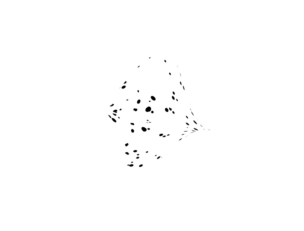

Rotation matrix: 
[[ 0.1808406  -0.58820029 -0.7882367 ]
 [ 0.61248655  0.6944222  -0.3776745 ]
 [ 0.76951732 -0.41448549  0.4858445 ]]
Transformation matrix: 
[[ 0.1808406  -0.58820029 -0.7882367   0.        ]
 [ 0.61248655  0.6944222  -0.3776745   0.        ]
 [ 0.76951732 -0.41448549  0.4858445   0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.76829475 -0.01197815 -0.50688685  0.39069863]
Angle: 1.3892470025924712




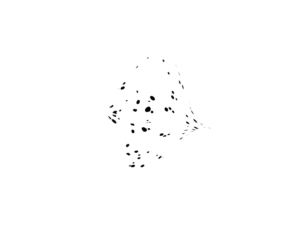

Rotation matrix: 
[[ 0.14971179 -0.59091865 -0.79271781]
 [ 0.61612781  0.68280997 -0.39262842]
 [ 0.77328708 -0.42963438  0.46630611]]
Transformation matrix: 
[[ 0.14971179 -0.59091865 -0.79271781  0.        ]
 [ 0.61612781  0.68280997 -0.39262842  0.        ]
 [ 0.77328708 -0.42963438  0.46630611  0.        ]
 [ 0.          0.          0.          1.        ]]
Elements: [ 0.7580943  -0.01220362 -0.51642813  0.39805287]
Angle: 1.4208207981059369





KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [71]:
shape = trimesh.load('/Users/yoni/Projects/CommonFate/scenes/scene_000/textured.obj')
render_img(shape, '', 200)

In [131]:
shape = trimesh.load('objects/scene_101/textured.obj')
mesh_node = pyrender.Mesh.from_trimesh(shape)
scene = pyrender.Scene(ambient_light=[500, 500, 500, 1000])
#camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
#light = pyrender.PointLight(color=[100.0, 100.0, 100.0], intensity=10.0)

c = 2**-0.5
pose = [[ 1,  0,  0,  0],
        [ 0,  c, -c, -3],
        [ 0,  c,  c,  3],
        [ 0,  0,  0,  1]]

scene.add(mesh_node, pose=np.eye(4), name='mesh')
shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
mesh_node = list(scene.get_nodes(name='mesh'))[0]
print(mesh_node)
r = mesh_node.rotation
t = mesh_node.translation
m = mesh_node.matrix
print(r,t,m)
#scene.add(light, pose=np.eye(4))
#scene.add(camera, pose=pose)
pyrender.Viewer(scene)

faces have mixed data, using slow fallback!


[0. 0. 0. 1.] [0. 0. 0.] [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


GLError: GLError(
	err = 1281,
	description = b'invalid value',
	baseOperation = glDeleteProgram,
	cArguments = (3,)
)

GLException: b'invalid framebuffer operation'

In [3]:
def render_file(obj_file):
    shape = trimesh.load(obj_file)
    return render_img(shape)

faces have mixed data, using slow fallback!


(<Figure size 432x288 with 1 Axes>,
 <trimesh.Trimesh(vertices.shape=(2744, 3), faces.shape=(7936, 3))>)

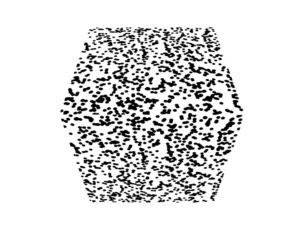

In [19]:
render_file('objects/scene_006/textured.obj')

(<Figure size 432x288 with 1 Axes>,
 <trimesh.Trimesh(vertices.shape=(1488900, 3), faces.shape=(3126660, 3))>)

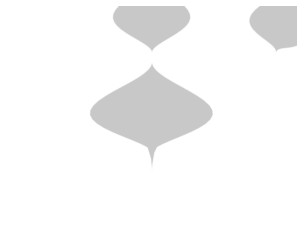

In [5]:
shape = trimesh.load('pyquadrics/all_superellipsoids.obj')

In [113]:
def create_vid(base_dir, output_name, frame_rate=25):
    ffmpeg_cmd = 'ffmpeg -framerate {} -i {}/images/fig_%d.png -vf format=yuv420p {}/{}'.format(frame_rate, base_dir, base_dir, output_name)
    print(ffmpeg_cmd)
    res = os.system(ffmpeg_cmd)
    print(res)

In [114]:
create_vid('objects', 'vid.mp4')

ffmpeg -framerate 25 -i objects/images/fig_%d.png -vf format=yuv420p objects/vid.mp4
256


faces have mixed data, using slow fallback!


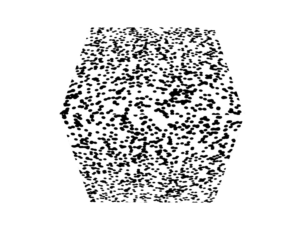

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_007/images/fig_%d.png -vf format=yuv420p objects/scene_007/vid.mp4


faces have mixed data, using slow fallback!


0


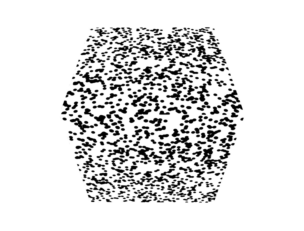

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_008/images/fig_%d.png -vf format=yuv420p objects/scene_008/vid.mp4


faces have mixed data, using slow fallback!


0


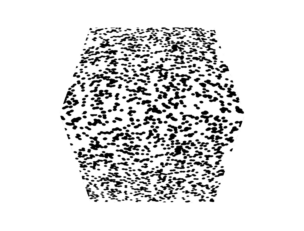

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_009/images/fig_%d.png -vf format=yuv420p objects/scene_009/vid.mp4


faces have mixed data, using slow fallback!


0


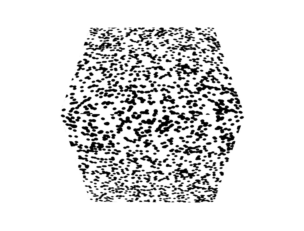

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_010/images/fig_%d.png -vf format=yuv420p objects/scene_010/vid.mp4


faces have mixed data, using slow fallback!


0


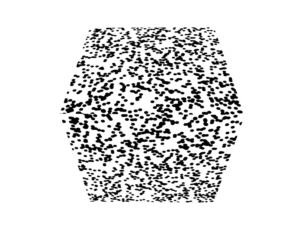

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_011/images/fig_%d.png -vf format=yuv420p objects/scene_011/vid.mp4


faces have mixed data, using slow fallback!


0


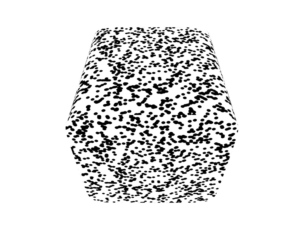

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_012/images/fig_%d.png -vf format=yuv420p objects/scene_012/vid.mp4


faces have mixed data, using slow fallback!


0


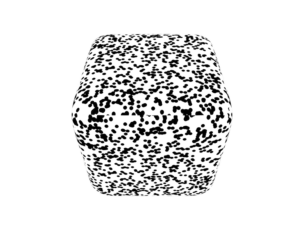

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_013/images/fig_%d.png -vf format=yuv420p objects/scene_013/vid.mp4


faces have mixed data, using slow fallback!


0


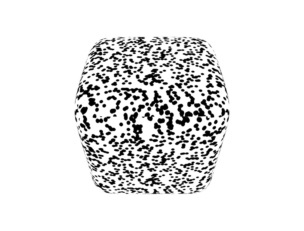

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_014/images/fig_%d.png -vf format=yuv420p objects/scene_014/vid.mp4


faces have mixed data, using slow fallback!


0


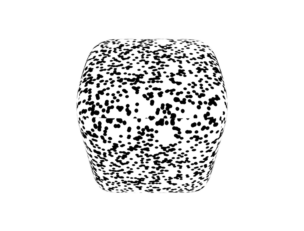

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_015/images/fig_%d.png -vf format=yuv420p objects/scene_015/vid.mp4


faces have mixed data, using slow fallback!


0


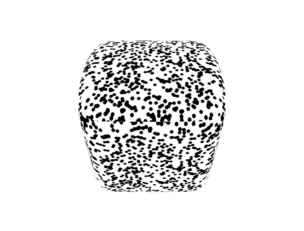

faces have mixed data, using slow fallback!


ValueError: Failed to initialize Pyglet window with an OpenGL >= 3+ context. If you're logged in via SSH, ensure that you're running your script with vglrun (i.e. VirtualGL). The internal error message was "list index out of range"

In [21]:
n_scenes = 143
n_frames = 200
for scene in range(7, n_scenes):
    base_dir = 'objects/scene_%03d'%scene
    obj_file = base_dir + '/textured.obj'

    fig = render_file(obj_file)
    plt.show(fig)

    shape = trimesh.load(obj_file)
    img_dir = os.path.join(base_dir, 'images')
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    for i in tqdm(range(n_frames)):
        shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
        fig, shape = render_img(shape)
        plt.savefig(img_dir + '/fig_%d.png'%i)
        plt.close()

    create_vid(base_dir, 'vid.mp4')

In [12]:
shape = trimesh.load(obj_file)
img_dir = os.path.join(base_dir, 'images')
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

for i in tqdm(range(200)):
    shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
    fig, shape = render_img(shape)
    plt.savefig(img_dir + '/fig_%d.png'%i)
    plt.close()

faces have mixed data, using slow fallback!


In [13]:
def create_vid(base_dir, output_name, frame_rate=25):
    ffmpeg_cmd = 'ffmpeg -framerate {} -i {}/images/fig_%d.png -vf format=yuv420p {}/{}'.format(frame_rate, base_dir, base_dir, output_name)
    print(ffmpeg_cmd)
    res = os.system(ffmpeg_cmd)
    print(res)

In [14]:
create_vid(base_dir, 'vid.mp4')

ffmpeg -framerate 25 -i objects/scene_0/images/fig_%d.png -vf format=yuv420p objects/scene_0/vid.mp4
0


### Generating a variety of superellipses

In [8]:
x_scale = 1
y_scale = 1
z_scale = 1

i = 0
for e1 in np.arange(0, 4.25, 0.25):
    for e2 in np.arange(e2, 4, 0.25):
        epsilons = [e1, e2]
        shape = shapes.Ellipsoid(x_scale, y_scale, z_scale, epsilons)
        fname = 'objects/superellipse_({}, {}).ply'.format(e1, e2)
        shape.save_as_mesh(fname)

Generated / Trimesh faces: (12, 3), (12, 3) ... Generated / Trimesh Vertices: (3, 10000), (8, 3) 
Generated / Trimesh faces: (796, 3), (796, 3) ... Generated / Trimesh Vertices: (3, 10000), (400, 3) 
Generated / Trimesh faces: (796, 3), (796, 3) ... Generated / Trimesh Vertices: (3, 10000), (400, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (16, 3), (16, 3) ... Generated / Trimesh Vertices: (3, 10000), (10, 3) 
Generated / Trimesh faces: (16, 3), (16, 3) ... Generated / Trimesh Vertices: (3, 10000),

Generated / Trimesh faces: (19404, 3), (19404, 3) ... Generated / Trimesh Vertices: (3, 10000), (9704, 3) 
Generated / Trimesh faces: (19404, 3), (19404, 3) ... Generated / Trimesh Vertices: (3, 10000), (9704, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Ve

In [4]:
idxs = [0, 1, 4, 5, 7, 10]
for idx in idxs:
    fname = 'objects/superellipse_%d.ply'%idx
    mesh = trimesh.load(fname)
    print(mesh.faces.shape, mesh.vertices.shape)
    render('objects/superellipse_%d.ply'%idx)

(12, 3) (8, 3)
(796, 3) (400, 3)
(784, 3) (394, 3)
(784, 3) (394, 3)
(784, 3) (394, 3)
(55314, 3) (9415, 3)


In [7]:
R

array([[-0.5924839 , -0.79265904, -0.14371667],
       [-0.05003803,  0.21426772, -0.97549246],
       [ 0.80402676, -0.57077228, -0.16661327]])

### Generating a variety of supertoroids

In [11]:
x_scale = 2
y_scale = 2
z_scale = 2
inner_radius = 2

i = 0
for e2 in np.arange(0, 2.75, 0.25):
    for e1 in np.arange(0, 2.75, 0.25):
        epsilons = [e1, e2]
        shape = shapes.Toroid(x_scale, y_scale, z_scale, inner_radius, epsilons)
        fname = 'objects/supertoroid_%d.ply'%i
        shape.save_as_mesh(fname)
        i += 1

### SuperEgg

In [6]:
x_scale = 3
y_scale = 3
z_scale = 4
eps = [.8, 1]
shape = shapes.Ellipsoid(x_scale, y_scale, z_scale, eps)
shape.save_as_mesh('objects/superegg.ply')
render('objects/superegg.ply')

In [30]:
def plot3d(points):
    print(list(points[0]))
    ax = plt.axes(projection='3d')
    ax.scatter(list(points[0, :]), list(points[1, :]), list(points[2, :]))
    plt.show()

In [31]:
x,y,z = superquadrics.superellipsoid([1,1], [1,1,1,1], n=100)

[-6.123233995736766e-17, -0.031727933498067816, -0.06342391965656455, -0.09505604330418281, -0.1265924535737493, -0.15800139597335003, -0.18925124436041021, -0.22031053278654075, -0.2511479871810792, -0.2817325568414298, -0.31203344569848707, -0.3420201433256688, -0.3716624556603275, -0.4009305354066138, -0.42979491208917175, -0.45822652172741046, -0.4861967361004687, -0.5136773915734064, -0.5406408174555977, -0.5670598638627709, -0.5929079290546405, -0.6181589862206053, -0.6427876096865394, -0.6667690005162916, -0.6900790114821121, -0.7126941713788629, -0.7345917086575333, -0.7557495743542584, -0.7761464642917568, -0.7957618405308322, -0.8145759520503357, -0.8325698546347714, -0.8497254299495144, -0.8660254037844387, -0.8814533634475821, -0.895993774291336, -0.9096319953545184, -0.9223542941045815, -0.9341478602651068, -0.9450008187146686, -0.9549022414440739, -0.9638421585599422, -0.9718115683235417, -0.9788024462147787, -0.984807753012208, -0.9898214418809328, -0.9938384644612541, -

TypeError: list indices must be integers or slices, not tuple

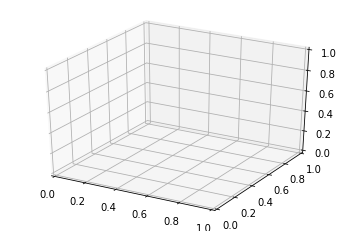

In [32]:
plot3d([x.flatten(),y.flatten(),z.flatten()])